<a href="https://colab.research.google.com/github/DataDoggo215/Flatiron_Capstone/blob/main/Densenet256x256_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras import datasets, layers, models
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import os, shutil

from PIL import Image
import PIL

random_state = 112221

In [ ]:
#Mount to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#check google GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#Business Understanding

# EDA

In [ ]:
#Upload and examine the train labels
train_labels = pd.read_csv('/content/gdrive/My Drive/Flatiron/trainLabels.csv')
train_labels

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35121,44347_right,0
35122,44348_left,0
35123,44348_right,0
35124,44349_left,0


We see that the labels have the image name attached, but the images itself. We can fix this by adding .jpeg file extension to the names. For our intended use case, we are also only interested if the patient has the disease or not. We can make this a binary classification problem.

In [ ]:
#Add image extensions
train_labels['image'] = train_labels['image'] + '.jpeg'
#Binary Classification
train_labels['level'].replace([1,2,3,4], 1, inplace = True)
train_labels['level'] = train_labels['level'].astype('str')

In [ ]:
train_labels

,image,level
0,10_left.jpeg,0
1,10_right.jpeg,0
2,13_left.jpeg,0
3,13_right.jpeg,0
4,15_left.jpeg,1
...,...,...
35121,44347_right.jpeg,0
35122,44348_left.jpeg,0
35123,44348_right.jpeg,0
35124,44349_left.jpeg,0


#Train/Test Split

The Dataset contains 35126 images. We will split the dataset first into a test and train split and then perform another split to keep a set for validation. The split of 10% was chosen because there are enough images to make a sizable test and validation sample at that threshold. 

In [ ]:
initial_train_sp, test_sp = train_test_split(train_labels, test_size=.1, stratify= train_labels['level'], random_state=random_state)

In [ ]:
train_sp, val_sp = train_test_split(initial_train_sp, test_size=.1, stratify= initial_train_sp['level'], random_state=random_state)

In [ ]:
test_reshaped = np.array(test_sp['level']).reshape(-1,1).astype(int)
test_reshaped

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

#Making Directories

In [ ]:
data_dir = '/content/gdrive/My Drive/Flatiron/kaggle_train'

In [ ]:
local_dataset_imgs_names = [file for file in os.listdir(data_dir)]
local_dataset_imgs_names[30000:30010]

['14702_left.jpeg',
 '1469_left.jpeg',
 '14698_left.jpeg',
 '1469_right.jpeg',
 '14698_right.jpeg',
 '14702_right.jpeg',
 '14712_left.jpeg',
 '14711_left.jpeg',
 '14711_right.jpeg',
 '14710_right.jpeg']

In [ ]:
print('There are', len(local_dataset_imgs_names), 'eye images.')

There are 35126 eye images.


In [ ]:
train_labels['level'].value_counts()

0    25810
1     9316
Name: level, dtype: int64

In [ ]:
local_split_dir = '/content/gdrive/My Drive/Flatiron/split'


train_folder = os.path.join(local_split_dir, 'train')
val_folder = os.path.join(local_split_dir, 'validation')
test_folder = os.path.join(local_split_dir, 'test')


In [ ]:
train_norm_dir = os.path.join(train_folder, '0')
train_positive_dir = os.path.join(train_folder, '1')

In [ ]:
normal= len(os.listdir(train_norm_dir))
positive= len(os.listdir(train_positive_dir))

train_count = normal + positive
weight_for_0 = (1 / normal) * (train_count) / 2.0
weight_for_1 = (1 / positive) * (train_count) / 2.0

weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Weight for class 0: 0.68
Weight for class 1: 1.89


In [ ]:
len(os.listdir(train_positive_dir ))

7545

In [ ]:
#Make Directories
#os.mkdir(train_folder)
#os.mkdir(val_folder)
#os.mkdir(test_folder)

In [ ]:
#make sub directroies
#for class_name in train_labels['level'].unique():
 #    for folder in ['train', 'validation', 'test']:
  #       os.mkdir(os.path.join('/content/gdrive/My Drive/Flatiron/split/', folder, class_name))


In [ ]:
img_dfs = [train_sp, val_sp, test_sp]
img_names_prezip = [list(df['image'].values) for df in img_dfs]
img_names = list(zip([('train'), ('validation'), ('test')], img_names_prezip))

In [ ]:
# for folder, img_list in img_names:
#      for image in img_list:
#         class_name = train_labels[train_labels['image'] == image]['level'].values[0]
#         origin = os.path.join(data_dir, image)
#         destination = os.path.join('/content/gdrive/My Drive/Flatiron/split/', folder, class_name, image)
#         shutil.copyfile(origin, destination)

## Model creation

In [ ]:
image_size = (256,256)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_folder,
    image_size=image_size,
    batch_size=batch_size,
)


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder,
    image_size=image_size,
    batch_size=batch_size,
)


Found 28451 files belonging to 2 classes.
Found 3162 files belonging to 2 classes.
Found 3513 files belonging to 2 classes.


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomRotation(0.1),
    ]
)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Modeling

DenseNet201

# DenseNet201 accounting for class imbalance

In [ ]:
base_model = keras.applications.DenseNet201(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256,256, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False

In [ ]:
# Create new model on top
inputs = keras.Input(shape=(256, 256, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = data_augmentation(inputs)

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                             

In [ ]:
epochs = 20
filepath = '/content/gdrive/My Drive/Flatiron/models/densenet256x256_weighted.hdf5'

callbacks = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,class_weight=weight,
)

Epoch 1/20
890/890 [==============================] - ETA: 0s - loss: 0.6743 - binary_accuracy: 0.6988
Epoch 1: val_loss improved from inf to 0.60284, saving model to /content/gdrive/My Drive/Flatiron/models/densenet256x256_weighted.hdf5
890/890 [==============================] - 1983s 2s/step - loss: 0.6743 - binary_accuracy: 0.6988 - val_loss: 0.6028 - val_binary_accuracy: 0.7546
Epoch 2/20
889/890 [============================>.] - ETA: 0s - loss: 0.6511 - binary_accuracy: 0.7221
Epoch 2: val_loss did not improve from 0.60284
890/890 [==============================] - 112s 126ms/step - loss: 0.6512 - binary_accuracy: 0.7221 - val_loss: 0.6138 - val_binary_accuracy: 0.7546
Epoch 3/20
889/890 [============================>.] - ETA: 0s - loss: 0.6478 - binary_accuracy: 0.7204
Epoch 3: val_loss did not improve from 0.60284
890/890 [==============================] - 110s 124ms/step - loss: 0.6479 - binary_accuracy: 0.7203 - val_loss: 0.6639 - val_binary_accuracy: 0.7356
Epoch 4/20
889/89

In [ ]:
base_model.trainable = True
model.summary()

epochs = 30

filepath = '/content/gdrive/My Drive/Flatiron/models/densenet256x256_weighted_tuned.hdf5'

callbacks = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds, class_weight=weight,
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                             

In [ ]:
load_file = '/content/gdrive/My Drive/Flatiron/models/densenet256x256_weighted_tuned.hdf5'
base_model = load_model(load_file)
base_model.evaluate(test_ds)

110/110 [==============================] - 154s 1s/step - loss: 0.4307 - binary_accuracy: 0.8218


[0.43069207668304443, 0.8218047022819519]

In [ ]:
pred = base_model.predict(test_ds)

In [ ]:
pred_transformed = np.exp(pred)/(1+np.exp(pred))

In [ ]:
preds = np.where(pred_transformed>0.5, 1,0)#if probability is less than .5 assign 0 if greater than 0 assign 1
cm  = confusion_matrix(test_reshaped, preds)

Text(0.5, 1.0, 'Densenet')

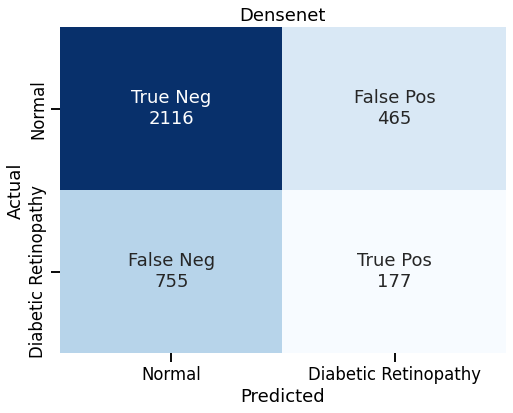

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Normal', 'Diabetic Retinopathy']

group_counts_1 = ['{0:0.0f}'.format(value) for value in cm.flatten()]
labels_1 = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts_1)]
labels_1 = np.asarray(labels_1).reshape(2,2)

sns.set_context('talk')
fig, ax= plt.subplots(figsize=(8,6))

sns.heatmap(cm, annot=labels_1, xticklabels=categories, yticklabels=categories, cbar=None, fmt='', cmap='Blues', ax=ax)
ax.set_ylabel('Actual')
ax.set_yticklabels(ax.get_yticklabels(), va="center")
ax.set_xlabel('Predicted')
ax.set_title('Densenet')

In [ ]:
print(f'Recall:    {recall_score(test_reshaped, preds)}')
print(f'Precision: {precision_score(test_reshaped, preds)}')
print(f'Accuracy:  {accuracy_score(test_reshaped, preds)}')
print(f'F1 score:  {f1_score(test_reshaped, preds)}')
print(f'AUROC:     {roc_auc_score(test_reshaped, pred)}')

Recall:    0.13733905579399142
Precision: 0.28507795100222716
Accuracy:  0.6797608881298036
F1 score:  0.18537291817523532
AUROC:     0.5126643530720534
